In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import dslabs_functions as dslab


In [66]:
df = pd.read_csv("../../../data/class_credit_score_mvi_simple_strategy.csv", index_col="ID")
print(df.shape)
df = df.dropna(subset=['Credit_Score'])
print(df.shape)

(100000, 37)
(100000, 37)


In [67]:
# df.describe().T
# Customer_ID, SSN, Name, Num_Credit_Card
df = df.drop(["Customer_ID", "SSN", "Name", "Num_Credit_Card"], axis=1)
print(df.shape)
df.describe().T

(100000, 33)


,count,mean,std,min,25%,50%,75%,max
Age,100000.0,1.106497e+02,6.862447e+02,-5.000000e+02,24.000000,33.000000,42.000000,8.698000e+03
Occupation,100000.0,8.755090e+04,3.654695e+04,2.935700e+04,62323.000000,95286.000000,99160.000000,1.803430e+05
Annual_Income,100000.0,1.764157e+05,1.429618e+06,7.005930e+03,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,100000.0,4.029085e+03,2.961364e+03,3.036454e+02,1792.084167,3093.745000,5371.525000,1.520463e+04
Num_Bank_Accounts,100000.0,1.709128e+01,1.174048e+02,-1.000000e+00,3.000000,6.000000,7.000000,1.798000e+03
Interest_Rate,100000.0,7.246604e+01,4.664226e+02,1.000000e+00,8.000000,13.000000,20.000000,5.797000e+03
NumofLoan,100000.0,3.009960e+00,6.264788e+01,-1.000000e+02,1.000000,3.000000,5.000000,1.496000e+03
Delay_from_due_date,100000.0,2.106878e+01,1.486010e+01,-5.000000e+00,10.000000,18.000000,28.000000,6.700000e+01
NumofDelayedPayment,100000.0,2.973837e+01,2.180176e+02,-3.000000e+00,9.000000,14.000000,18.000000,4.397000e+03
ChangedCreditLimit,100000.0,1.036834e+01,6.719627e+00,-6.490000e+00,5.420000,9.400000,14.660000,3.697000e+01


In [68]:
def handle_outliers(data: pd.DataFrame, strategy: str):
    data = data.copy(deep=True)
    summary = data.describe()
    for var in data.columns:
        top, bottom = dslab.determine_outlier_thresholds_for_var(summary[var], std_based=False, threshold=3.0)

        if strategy == "drop":
            data = data[(data[var] >= bottom) & (data[var] <= top)]
        elif strategy == "replace_median":
            non_outliers = data[(data[var] >= bottom) & (data[var] <= top)]
            median = non_outliers[var].median()
            data[var] = data[var].apply(
                lambda x: median if x > top or x < bottom else x
            )
        elif strategy == "truncate":
            data[var] = data[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        else:
            raise ValueError("Not Implemented")

    return data


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import dslabs_functions as dslabs
import seaborn as sns

In [70]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, auc, f1

In [71]:
def generate_eval_chart(df, clf):
    target = "Credit_Score"
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    print(f"Train#={len(X_train)} Test#={len(X_test)}")
    print(f"Labels={pd.unique(y_train)}")
    print(X_train.shape, y_train.shape)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf.fit(X_train_scaled, y_train)
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)

    metrics_train = calculate_metrics(y_train, y_train_pred)
    metrics_test = calculate_metrics(y_test, y_test_pred)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1-Score'],
        'Training': metrics_train,
        'Test': metrics_test
    })
    metrics_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    sns.barplot(ax=axs[0], x='Metric', y='Score', hue='Set', data=metrics_melted)
    axs[0].bar_label(axs[0].containers[0], fmt="%.2f")
    axs[0].bar_label(axs[0].containers[1], fmt="%.2f")

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, ax=axs[1], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    return fig, axs

Train#=35123 Test#=8781
Labels=[1. 0.]
(35123, 32) (35123,)


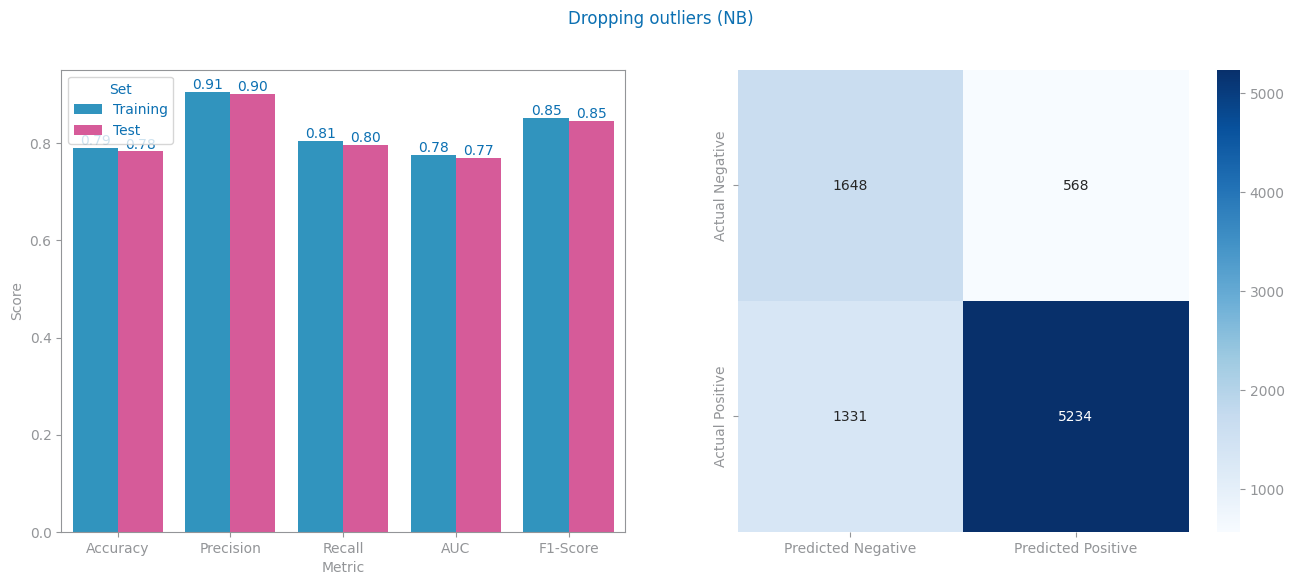

In [72]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="drop"), GaussianNB())
fig.suptitle("Dropping outliers (NB)")
plt.savefig(f"images/service_dropping_outliers_nb.png")

Train#=80000 Test#=20000
Labels=[1. 0.]
(80000, 32) (80000,)


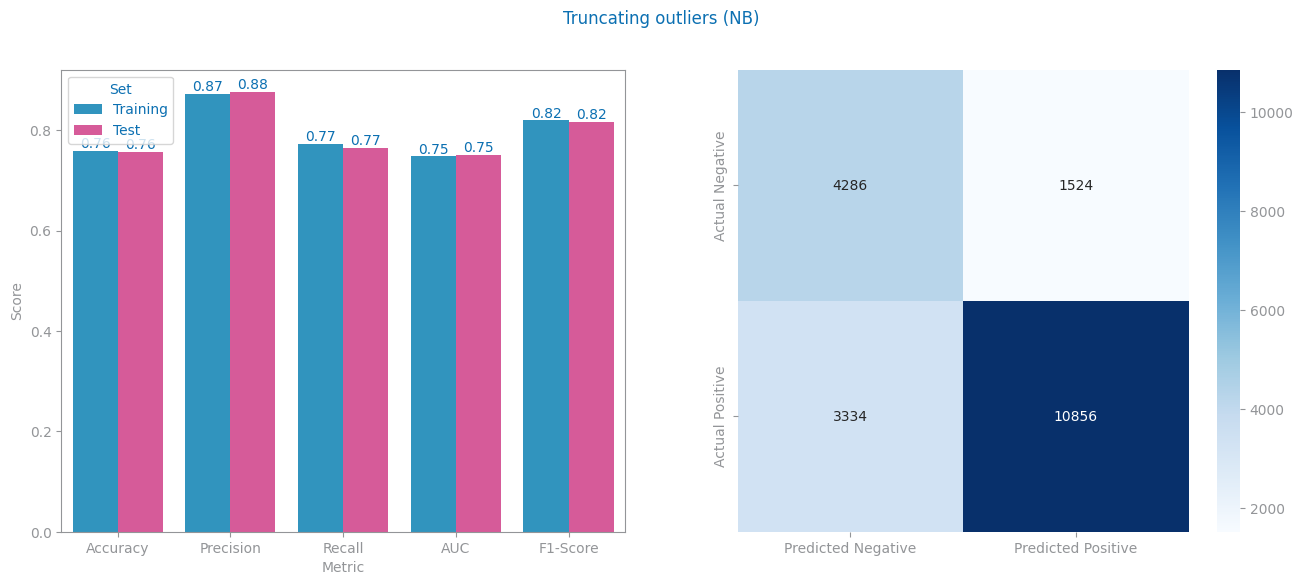

In [73]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="truncate"), GaussianNB())
fig.suptitle("Truncating outliers (NB)")
plt.savefig(f"images/service_truncating_outliers_nb.png")

Train#=35123 Test#=8781
Labels=[1. 0.]
(35123, 32) (35123,)


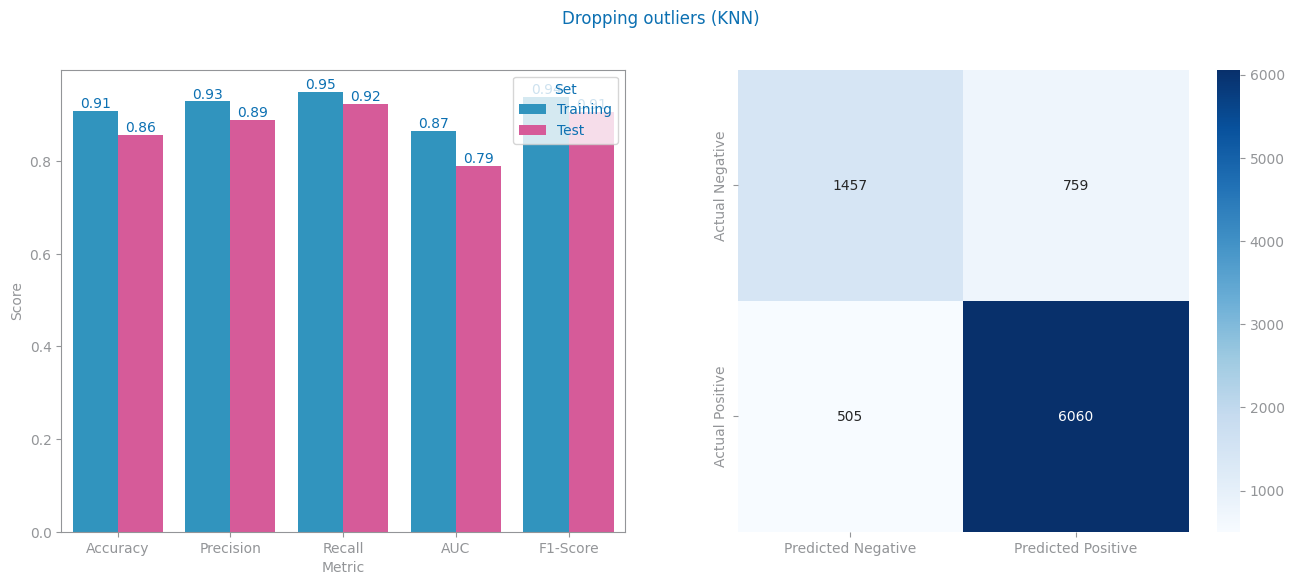

In [74]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="drop"), KNeighborsClassifier())
fig.suptitle("Dropping outliers (KNN)")
plt.savefig(f"images/service_dropping_outliers_knn.png")

Train#=80000 Test#=20000
Labels=[1. 0.]
(80000, 32) (80000,)


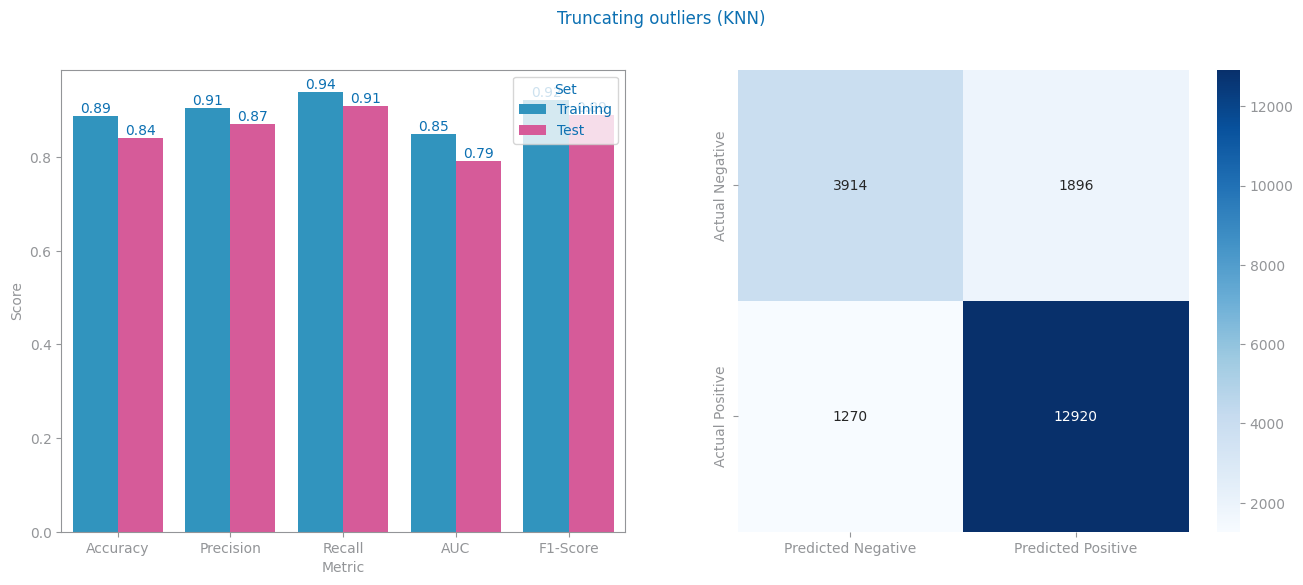

In [75]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="truncate"), KNeighborsClassifier())
fig.suptitle("Truncating outliers (KNN)")
plt.savefig(f"images/service_truncating_outliers_knn.png")

In [76]:
df_dropped = handle_outliers(df, strategy="drop")
print(df_dropped.shape)
print(df_dropped.columns)
df_dropped.to_csv("../../../data/class_credit_score_outliers_removed.csv")

(43904, 33)
Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Interest_Rate', 'NumofLoan',
       'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit',
       'NumCreditInquiries', 'CreditMix', 'OutstandingDebt',
       'CreditUtilizationRatio', 'Credit_History_Age', 'Payment_of_Min_Amount',
       'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance',
       'Credit_Score', 'sin_month', 'cos_month', 'PaydayLoan', 'AutoLoan',
       'Credit-BuilderLoan', 'StudentLoan', 'NotSpecified', 'MortgageLoan',
       'HomeEquityLoan', 'DebtConsolidationLoan', 'PersonalLoan', 'spent',
       'value_payments'],
      dtype='object')
